In [1]:
from pyfreefem import FreeFemRunner, readFFArray
from nullspace_optimizer import Optimizable, nlspace_solve
from pymedit import Mesh, P1Function, trunc, Mesh3D, cube, mmg3d, generate3DMesh, P1Function3D, trunc3DMesh
from pymedit import saveToVtk, advect, P1Vector3D, mshdist
import numpy as np
import shutil
import pandas as pd

output='output/caseCylinderTest' #1
import os
os.makedirs(output,exist_ok=True)

config={'OUTPUT':output}

N=8 #number of cores
i = format(0,'04d')
meshes='output'
M = Mesh3D(meshes+"/ThCoarse.mesh")
M.save(output+"/Th00.mesh")

preamble="""
func int readSolFile(mesh & Th, string fileName, real[int] & phi){
    ifstream f(fileName);
    string dummy="";
    while(dummy(0:2)!="Sol"){
        f>>dummy;
    }
    int n;
    f >> n;
    if(n!=Th.nv){
        cout << "Error : the number of vertices in the file "+fileName+" does not correspond to the mesh in memory"<< endl;
        exit(1);
    }
    f >> dummy;
    f >> dummy;
    for(int i=0;i<Th.nv;i++){
        f>>phi[i];
    }
}

func int saveArray(string fileName, real[int] &value){
    ofstream file(fileName);
    file.precision(16);
    file << value;
}

func int readData(string fileName, real[int] &data){
    {
        ifstream f(fileName);
        f>>data;
    }
}

include "macros.edp"
load "medit"
load "msh3"
load "iovtk"

int region1 = 20; //interior circle
int region2 = 3; //exterior donuts
int empty = 2;
real k1=0.15;
real k2=0.1; //0.1*1e-6; //thermal diffusivity D or alpha of rubber;
real rhocp=1e2;
real vtarget=0.0942477796; 
real nu = 1e-2; //1e-3; //1e-6
real beta=2e1;//2e1; //1e2
"""

mesh_code='''
load "PETSc"
macro dimension()3 //EOM
include "macro_ddm.idp"

mesh3 ThBox=readmesh3("$OUTPUT/Th00.mesh");
savevtk("$OUTPUT/ThBox.vtu",ThBox);
mesh3 Th=trunc(ThBox, ((region == region1) || (region == region2)));
savemesh(Th,"$OUTPUT/Th.mesh");
{
    ofstream f("$OUTPUT/V.gp");
    f.precision(16);
    f << int3d(Th,region2,qforder=1)(1.) - vtarget  << endl;
}
'''

solve_kappa = """
mesh3 ThGlobal = Th;

int[int] n2o;
macro ThN2O() n2o // this tells buildDmesh to keep the local to global correspondence
buildDmesh(Th)

fespace PhGlobal(ThGlobal, P1);

PhGlobal kappaGlobal, kappasum, dOmegaGlobal, nx, ny, nz;

if (mpirank==0){
    //save the solution
    kappasum = 1./0.1;
    savesol("$OUTPUT/kappa.sol",ThGlobal,kappasum);
}


"""

interpolate_ns="""
                mesh3 ThBox=readmesh3("$OUTPUT/Th.mesh");
                mesh3 Th=trunc(ThBox, ((region == region1) || (region == region2)));
                mesh3 Th1=trunc(Th, (region == region1));
                savemesh(Th,"$OUTPUT/Th.mesh");

                fespace Phnew(Th1, [P2,P2,P2,P1]);
                Phnew [uxnew,uynew,uznew,pnew];

                [uxnew,uynew,uznew,pnew] = [(0.1^2 - (y-0.5)^2 - (z-0.5)^2)/0.01,0.,0.,0.];
                savesol("$OUTPUT/ux.sol",Th1,uxnew);
                savesol("$OUTPUT/uy.sol",Th1,uynew);
                savesol("$OUTPUT/uz.sol",Th1,uznew);
            """


def computeU(mesh,t):
    FreeFemRunner([preamble, mesh_code, solve_kappa],config,run_dir=output,run_file='solve.edp',debug=1).execute({'MESH':mesh},ncpu=N)
    FreeFemRunner([preamble, interpolate_ns],config,run_dir=output,run_file='interpolate_ns.edp',debug=1).execute({'MESH':mesh})
    os.system(f"time mpiexec -n 1 ./MatrixBinaryPetscTP2RealValues {output} {t} -pc_type lu -pc_factor_mat_solver_type superlu_dist -ksp_monitor ")
    
    with open(output+'/J.gp','r') as f:
        J = float(f.readlines()[0])
    with open(output+'/V.gp','r') as f:
        V = float(f.readlines()[0])
    return (J,V)

code_sensitivity=r"""
load "PETSc"
macro dimension()3 //EOM
include "macro_ddm.idp"

mesh3 ThBox=readmesh3("$MESH");
mesh3 ThBoxGlobal = ThBox;
mesh3 Th2 = readmesh3("$OUTPUT/Th2.mesh");

int[int] n2oBox;
macro ThBoxN2O() n2oBox // this tells buildDmesh to keep the local to global correspondence
buildDmesh(ThBox)

// Variational space
fespace Ph2(Th2, P1);
fespace PhBox(ThBoxGlobal, P1);

PhBox dOmegaBox,kappaP1,nx3,ny3,nz3,thetax2,thetay2,thetaz2;
Ph2 T2,R2,T0;

T2[] = readsol("$OUTPUT/T2.sol");
R2[] = readsol("$OUTPUT/R2.sol");
T0 = 0.;

if (mpirank==0){
    int[int] Order = [1];
    string DataName = "T";
    savevtk("$OUTPUT/T.vtu",Th2,T2,dataname=DataName, order=Order);
    //savevtk("$OUTPUT/R.vtu",Th2,R2);
}

if (mpirank==0){
    nx3 = 0.; ny3=(y-0.5)/sqrt((y-0.5)^2+(z-0.5)^2); nz3 = (z-0.5)/sqrt((y-0.5)^2+(z-0.5)^2);
    thetax2 = -nx3; thetay2 = -ny3; thetaz2 = -nz3;
    kappaP1 = 1./sqrt((y-0.5)^2+(z-0.5)^2);

    PhBox  dxthetax, dythetax, dzthetax, dxthetay, dythetay, dzthetay, dxthetaz, dythetaz, dzthetaz;

    dxthetax = 0.;
    dythetax = 0.;
    dzthetax = 0.;
    
    dxthetay = 0.;
    dythetay = -(z-0.5)^2/((y-0.5)^2 + (z-0.5)^2)^1.5;
    dzthetay = ((y-0.5)*(z-0.5))/((y-0.5)^2 + (z-0.5)^2)^1.5;
    
    dxthetaz = 0.;
    dythetaz = ((y-0.5)*(z-0.5))/((y-0.5)^2 + (z-0.5)^2)^1.5;
    dzthetaz = -(y-0.5)^2/((y-0.5)^2 + (z-0.5)^2)^1.5;
    
    //volume
    real val1 = int2d(ThBoxGlobal,10,qforder=3)((dxthetax+dythetay+dzthetaz - tr(MatrixByVector([dxthetax,dythetax,dzthetax,
                                                                                       dxthetay,dythetay,dzthetay,
                                                                                       dxthetaz,dythetaz,dzthetaz],[nx3,ny3,nz3]))*[nx3,ny3,nz3] )*(beta^2*T2^2 - beta*T2*R2))
                +int3d(ThBoxGlobal,region2,qforder=3)(-(dxthetax+dythetay+dzthetaz)*k2*tr(grad(T2))*grad(R2) + k2*tr(grad(R2))*MatrixByVector([2.*dxthetax,dxthetay+dythetax,dxthetaz+dzthetax,
                                                                                                                                     dythetax+dxthetay, 2.*dythetay,dythetaz+dzthetay,
                                                                                                                                     dzthetax+dxthetaz,dzthetay+dythetaz,2.*dzthetaz], grad(T2)));

    //volume
    real val2 = int2d(ThBoxGlobal,10,qforder=3)((dxthetax+dythetay+dzthetaz - tr(MatrixByVector([dxthetax,dythetax,dzthetax,
                                                                                       dxthetay,dythetay,dzthetay,
                                                                                       dxthetaz,dythetaz,dzthetaz],[nx3,ny3,nz3]))*[nx3,ny3,nz3] )*(beta^2*T2^2 - beta*T2*R2))
                +int3d(ThBoxGlobal,region2,qforder=3)(-(dxthetax+dythetay+dzthetaz)*k2*tr(grad(T2))*grad(R2) + k2*tr(grad(R2))*MatrixByVector([2.*dxthetax,dxthetay+dythetax,dxthetaz+dzthetax,
                                                                                                                                     dythetax+dxthetay, 2.*dythetay,dythetaz+dzthetay,
                                                                                                                                     dzthetax+dxthetaz,dzthetay+dythetaz,2.*dzthetaz], grad(T2)));
                                                                                                                                     
    {
        ofstream f("$OUTPUT/val1.gp");
        f.precision(16);
        f << val1  << endl;
    }
    {
        ofstream f("$OUTPUT/val2.gp");
        f.precision(16);
        f << val2  << endl;
    }
}

"""
def sensitivity(mesh):
    FreeFemRunner([preamble,code_sensitivity],config,run_dir=output,run_file='sensitivities.edp',debug=1).execute(config={'MESH':mesh},ncpu=N)

    with open(output+'/val1.gp','r') as f:
        val1 = float(f.readlines()[0])
    with open(output+'/val2.gp','r') as f:
        val2 = float(f.readlines()[0])
    return (val1,val2)

import matplotlib.pyplot as plt

## Initial solution and J ##
mesh0 = output+"/Th00.mesh"
(J,V) = computeU(mesh0,0)
(val1,val2) = sensitivity(mesh0)

T = 10.**np.arange(-3,-0.8,0.2)
delta1 = []
delta2 = []
for t in T:
    (Jt,Vt) = computeU(mesh0,t)

    d1 = np.abs(Jt - J - t*val1)
    print(f"t={np.log10(t)},Jt={Jt},J={J},Jt-J={Jt-J},der={t*val1},delta1={np.log10(d1)}")
    delta1.append(d1)

    open(output+'/delta1.txt', 'w').close()
    df = pd.DataFrame(data=np.array(delta1),columns=['delta1'])
    df.to_csv(output+'/delta1.txt', header=None, index=None, sep=' ', mode='a')


    d2 = np.abs(Jt - J - t*val2)
    print(f"t={np.log10(t)},Jt={Jt},J={J},Jt-J={Jt-J},der={t*val2},delta2={np.log10(d2)}")
    delta2.append(d2)

    open(output+'/delta2.txt', 'w').close()
    df = pd.DataFrame(data=np.array(delta2),columns=['delta2'])
    df.to_csv(output+'/delta2.txt', header=None, index=None, sep=' ', mode='a')

ff-mpirun -np 8 output/caseCylinderTest/solve.edp -v -1 -nw (16.25s)
FreeFem++ output/caseCylinderTest/interpolate_ns.edp -v -1 -nw (7.74s)
tau = 0, thetay(1,1,1) = -0
  0 KSP Residual norm 1.168579237596e+04
  1 KSP Residual norm 2.918983915018e-10
Text = 0, int2d = 146.166
  0 KSP Residual norm 4.777742835881e+03
  1 KSP Residual norm 9.741798663620e-11
ff-mpirun -np 8 output/caseCylinderTest/sensitivities.edp -v -1 -nw

3820.48user 7.05system 1:03:48elapsed 99%CPU (0avgtext+0avgdata 6961216maxresident)k
43080inputs+71424outputs (163major+2739021minor)pagefaults 0swaps


 (33.56s)
ff-mpirun -np 8 output/caseCylinderTest/solve.edp -v -1 -nw (22.15s)
FreeFem++ output/caseCylinderTest/interpolate_ns.edp -v -1 -nw (8.39s)
tau = 0.001, thetay(1,1,1) = -0.000707107
  0 KSP Residual norm 1.169448984470e+04
  1 KSP Residual norm 1.195070117386e-10
Text = 0, int2d = 145.332
  0 KSP Residual norm 4.772361309407e+03
  1 KSP Residual norm 5.630513579576e-11
t=-3.0,Jt=145.33228,J=146.16566,Jt-J=-0.8333800000000053,der=-0.8307361999499322,delta1=-2.577771393525862
t=-3.0,Jt=145.33228,J=146.16566,Jt-J=-0.8333800000000053,der=-0.8307361999499322,delta2=-2.577771393525862
ff-mpirun -np 8 output/caseCylinderTest/solve.edp -v -1 -nw

3513.45user 7.26system 58:41.43elapsed 99%CPU (0avgtext+0avgdata 6961248maxresident)k
0inputs+71424outputs (1major+2739087minor)pagefaults 0swaps


 (16.54s)
FreeFem++ output/caseCylinderTest/interpolate_ns.edp -v -1 -nw (7.68s)
tau = 0.00158489, thetay(1,1,1) = -0.00112069
  0 KSP Residual norm 1.169957955910e+04
  1 KSP Residual norm 1.008721776986e-10
Text = 0, int2d = 144.843
  0 KSP Residual norm 4.769155159115e+03
  1 KSP Residual norm 5.788091295034e-11
t=-2.8,Jt=144.84256,J=146.16566,Jt-J=-1.3231000000000108,der=-1.3166281480316624,delta1=-2.1889714249657266
t=-2.8,Jt=144.84256,J=146.16566,Jt-J=-1.3231000000000108,der=-1.3166281480316624,delta2=-2.1889714249657266
ff-mpirun -np 8 output/caseCylinderTest/solve.edp -v -1 -nw

2846.96user 6.47system 47:33.99elapsed 99%CPU (0avgtext+0avgdata 6962940maxresident)k
0inputs+71424outputs (1major+2739347minor)pagefaults 0swaps


 (16.31s)
FreeFem++ output/caseCylinderTest/interpolate_ns.edp -v -1 -nw (7.73s)
tau = 0.00251189, thetay(1,1,1) = -0.00177617
  0 KSP Residual norm 1.170764987490e+04
  1 KSP Residual norm 3.682362202722e-10
Text = 0, int2d = 144.063
  0 KSP Residual norm 4.763983838599e+03
  1 KSP Residual norm 3.707554013512e-11
t=-2.5999999999999996,Jt=144.06292,J=146.16566,Jt-J=-2.1027400000000114,der=-2.086714988818066,delta1=-1.7952016587666768
t=-2.5999999999999996,Jt=144.06292,J=146.16566,Jt-J=-2.1027400000000114,der=-2.086714988818066,delta2=-1.7952016587666768
ff-mpirun -np 8 output/caseCylinderTest/solve.edp -v -1 -nw

2838.38user 6.44system 47:25.37elapsed 99%CPU (0avgtext+0avgdata 6962824maxresident)k
0inputs+71416outputs (1major+2739335minor)pagefaults 0swaps


 (16.11s)
FreeFem++ output/caseCylinderTest/interpolate_ns.edp -v -1 -nw (7.49s)
tau = 0.00398107, thetay(1,1,1) = -0.00281504
  0 KSP Residual norm 1.172044871565e+04
  1 KSP Residual norm 9.642307496047e-11
Text = 0, int2d = 142.818
  0 KSP Residual norm 4.755557649451e+03
  1 KSP Residual norm 3.119983960110e-11
t=-2.3999999999999995,Jt=142.81846,J=146.16566,Jt-J=-3.347200000000015,der=-3.3072203803843228,delta1=-1.398161342273723
t=-2.3999999999999995,Jt=142.81846,J=146.16566,Jt-J=-3.347200000000015,der=-3.3072203803843228,delta2=-1.398161342273723
ff-mpirun -np 8 output/caseCylinderTest/solve.edp -v -1 -nw

2818.89user 6.47system 47:05.93elapsed 99%CPU (0avgtext+0avgdata 6962708maxresident)k
0inputs+71424outputs (1major+2739342minor)pagefaults 0swaps


 (16.17s)
FreeFem++ output/caseCylinderTest/interpolate_ns.edp -v -1 -nw (7.56s)
tau = 0.00630957, thetay(1,1,1) = -0.00446154
  0 KSP Residual norm 1.174075026696e+04
  1 KSP Residual norm 1.657319900952e-10
Text = 0, int2d = 140.824
  0 KSP Residual norm 4.741606924026e+03
  1 KSP Residual norm 9.193333026198e-11
t=-2.1999999999999993,Jt=140.82365,J=146.16566,Jt-J=-5.342010000000016,der=-5.241591066839769,delta1=-0.9981843968341958
t=-2.1999999999999993,Jt=140.82365,J=146.16566,Jt-J=-5.342010000000016,der=-5.241591066839769,delta2=-0.9981843968341958
ff-mpirun -np 8 output/caseCylinderTest/solve.edp -v -1 -nw

2810.85user 6.49system 46:57.90elapsed 99%CPU (0avgtext+0avgdata 6962820maxresident)k
0inputs+71408outputs (1major+2739343minor)pagefaults 0swaps


 (16.32s)
FreeFem++ output/caseCylinderTest/interpolate_ns.edp -v -1 -nw (7.58s)
tau = 0.01, thetay(1,1,1) = -0.00707107
  0 KSP Residual norm 1.177295093748e+04
  1 KSP Residual norm 1.687937308679e-10
Text = 0, int2d = 137.604
  0 KSP Residual norm 4.717923953595e+03
  1 KSP Residual norm 7.893795860567e-11
t=-1.9999999999999991,Jt=137.6043,J=146.16566,Jt-J=-8.561360000000008,der=-8.307361999499339,delta1=-0.595169702179054
t=-1.9999999999999991,Jt=137.6043,J=146.16566,Jt-J=-8.561360000000008,der=-8.307361999499339,delta2=-0.595169702179054
ff-mpirun -np 8 output/caseCylinderTest/solve.edp -v -1 -nw

2798.00user 6.39system 46:44.94elapsed 99%CPU (0avgtext+0avgdata 6962808maxresident)k
0inputs+71424outputs (1major+2739343minor)pagefaults 0swaps


 (15.95s)
FreeFem++ output/caseCylinderTest/interpolate_ns.edp -v -1 -nw (7.55s)
tau = 0.0158489, thetay(1,1,1) = -0.0112069
  0 KSP Residual norm 1.182396957645e+04
  1 KSP Residual norm 1.096533811116e-10
Text = 0, int2d = 132.351
  0 KSP Residual norm 4.676111636480e+03
  1 KSP Residual norm 3.284115939938e-11
t=-1.799999999999999,Jt=132.35112,J=146.16566,Jt-J=-13.814539999999994,der=-13.16628148031665,delta1=-0.1882517668422209
t=-1.799999999999999,Jt=132.35112,J=146.16566,Jt-J=-13.814539999999994,der=-13.16628148031665,delta2=-0.1882517668422209
ff-mpirun -np 8 output/caseCylinderTest/solve.edp -v -1 -nw

2787.28user 6.45system 46:34.28elapsed 99%CPU (0avgtext+0avgdata 6962696maxresident)k
0inputs+71416outputs (1major+2739334minor)pagefaults 0swaps


 (16.46s)
FreeFem++ output/caseCylinderTest/interpolate_ns.edp -v -1 -nw (7.61s)
tau = 0.0251189, thetay(1,1,1) = -0.0177617
  0 KSP Residual norm 1.190439840903e+04
  1 KSP Residual norm 1.784360147788e-10
Text = 0, int2d = 123.621
  0 KSP Residual norm 4.597587145560e+03
  1 KSP Residual norm 3.347555749738e-11
t=-1.5999999999999988,Jt=123.6214,J=146.16566,Jt-J=-22.54426000000001,der=-20.867149888180702,delta1=0.22456157744545596
t=-1.5999999999999988,Jt=123.6214,J=146.16566,Jt-J=-22.54426000000001,der=-20.867149888180702,delta2=0.22456157744545596
ff-mpirun -np 8 output/caseCylinderTest/solve.edp -v -1 -nw

2774.49user 6.46system 46:21.50elapsed 99%CPU (0avgtext+0avgdata 6962760maxresident)k
0inputs+71416outputs (1major+2739344minor)pagefaults 0swaps


 (15.97s)
FreeFem++ output/caseCylinderTest/interpolate_ns.edp -v -1 -nw (7.44s)
tau = 0.0398107, thetay(1,1,1) = -0.0281504
  0 KSP Residual norm 1.202852997537e+04
  1 KSP Residual norm 2.127972457256e-10
Text = 0, int2d = 108.65
  0 KSP Residual norm 4.434537507602e+03
  1 KSP Residual norm 6.302940877659e-11
t=-1.3999999999999986,Jt=108.64981,J=146.16566,Jt-J=-37.51585,der=-33.07220380384329,delta1=0.6477394730470313
t=-1.3999999999999986,Jt=108.64981,J=146.16566,Jt-J=-37.51585,der=-33.07220380384329,delta2=0.6477394730470313
ff-mpirun -np 8 output/caseCylinderTest/solve.edp -v -1 -nw

2767.95user 6.38system 46:14.89elapsed 99%CPU (0avgtext+0avgdata 6962864maxresident)k
0inputs+71416outputs (1major+2739349minor)pagefaults 0swaps


 (15.99s)
FreeFem++ output/caseCylinderTest/interpolate_ns.edp -v -1 -nw (7.55s)
tau = 0.0630957, thetay(1,1,1) = -0.0446154
  0 KSP Residual norm 1.219898485015e+04
  1 KSP Residual norm 1.575953694312e-10
Text = 0, int2d = 81.3408
  0 KSP Residual norm 4.027738584986e+03
  1 KSP Residual norm 1.004769619079e-10
t=-1.1999999999999984,Jt=81.340804,J=146.16566,Jt-J=-64.824856,der=-52.41591066839779,delta1=1.0937348712545953
t=-1.1999999999999984,Jt=81.340804,J=146.16566,Jt-J=-64.824856,der=-52.41591066839779,delta2=1.0937348712545953
ff-mpirun -np 8 output/caseCylinderTest/solve.edp -v -1 -nw

2756.69user 6.44system 46:03.69elapsed 99%CPU (0avgtext+0avgdata 6962712maxresident)k
0inputs+71416outputs (1major+2739350minor)pagefaults 0swaps


 (15.94s)
FreeFem++ output/caseCylinderTest/interpolate_ns.edp -v -1 -nw (7.48s)
tau = 0.1, thetay(1,1,1) = -0.0707107
  0 KSP Residual norm 1.189247168105e+04
  1 KSP Residual norm 6.821772292562e-10
Text = 0, int2d = 15.3423
  0 KSP Residual norm 1.911432499415e+03
  1 KSP Residual norm 1.555387822593e-11
t=-0.9999999999999982,Jt=15.342283,J=146.16566,Jt-J=-130.823377,der=-83.07361999499355,delta1=1.678971165832784
t=-0.9999999999999982,Jt=15.342283,J=146.16566,Jt-J=-130.823377,der=-83.07361999499355,delta2=1.678971165832784


2756.10user 6.45system 46:03.11elapsed 99%CPU (0avgtext+0avgdata 6962812maxresident)k
0inputs+71472outputs (1major+2739338minor)pagefaults 0swaps


<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_10675/2421540638.py:3: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel('$\delta(t)$')
/tmp/ipykernel_10675/2421540638.py:9: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel('$\delta(t)$')


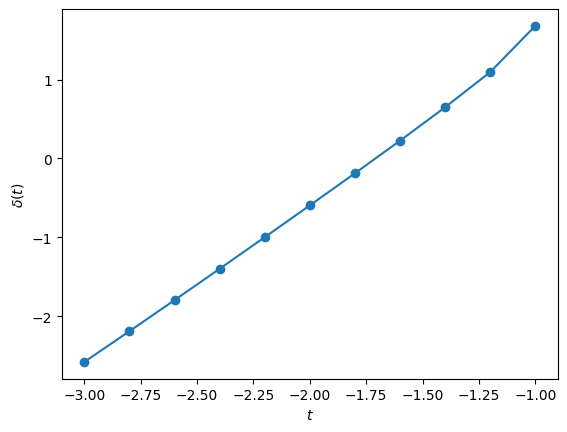

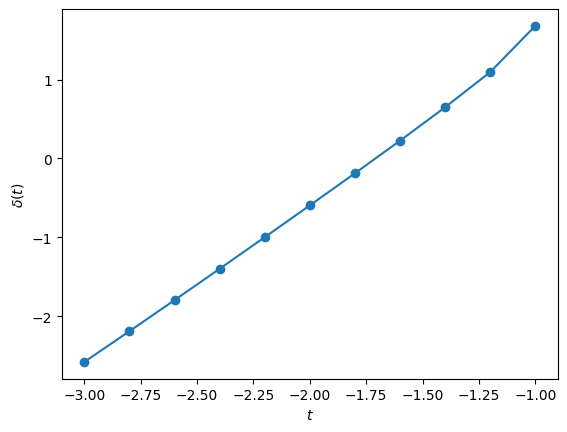

In [2]:
plt.plot(np.log10(T),np.log10(delta1),'-o')
plt.xlabel('$t$')
plt.ylabel('$\delta(t)$')
plt.savefig(output+'/SurfaceShapeDerivativeValidation.png')

plt.figure()
plt.plot(np.log10(T),np.log10(delta2),'-o')
plt.xlabel('$t$')
plt.ylabel('$\delta(t)$')
plt.savefig(output+'/VolumeShapeDerivativeValidation.png')

In [3]:
from sklearn.linear_model import LinearRegression

X = np.log10(T).reshape(-1, 1) 
y = np.log10(delta1)
reg = LinearRegression().fit(X, y)
order1 = reg.coef_[0]
print(f"order surface = {order1}")

X = np.log10(T).reshape(-1, 1) 
y = np.log10(delta2)
reg = LinearRegression().fit(X, y)
order2 = reg.coef_[0]
print(f"order volume = {order2}")

order surface = 2.081760902115724
order volume = 2.081760902115724
